In [1]:
from slsim.Pipelines.halos_pipeline import HalosSkyPyPipeline
from slsim.Halos.halos_lens import HalosLens
import numpy as np
from scipy import stats
from scipy.stats import spearmanr, kendalltau
import seaborn as sns
from slsim.Halos.halos_plus_glass import run_halos_without_kde_by_multiprocessing
from astropy.cosmology import FlatLambdaCDM, default_cosmology
import matplotlib.pyplot as plt
from slsim.Halos.halos_plus_glass import (
    read_glass_data,
    skyarea_form_n,
    generate_samples_from_glass,
    halos_plus_glass,
convergence_mean_0,
run_certain_redshift_lensext_kde_by_multiprocessing
)
import os
from astropy.cosmology import FlatLambdaCDM
from slsim.Halos.halos_plus_glass import run_halos_without_kde_by_multiprocessing
import seaborn as sns
from scipy import stats
import pandas as pd

/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


         z                 mass       
------------------- ------------------
0.48406622062893145 2528753029783.9507
 0.8007354274653015  4763593060043.565
 1.9239340246804981 2313298764108.7134
  3.683241592153322 1650626098531.8376
 1.4998285207476052 1003321686033.5634
 2.3737656641652314 2182029582853.1016
0.21060224299604244  1646610444908.338
 1.6902264097790336 1620359749421.9893
 1.5766347865933277 1272616161740.9043
 1.2958683070858055 1135511794338.4045


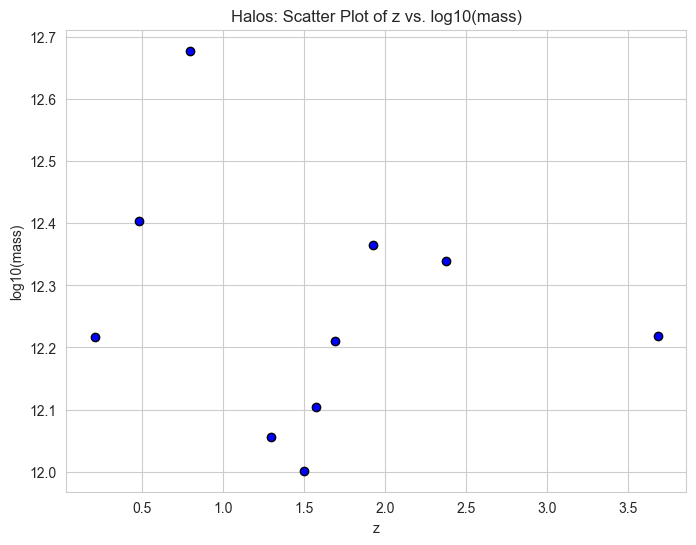

In [2]:
pipeline = HalosSkyPyPipeline(sky_area=0.00036,                  # in square degrees
                                                    m_max="1.0E+16",                # in solar masses   
                                                    m_min="1.0E+12", 
                                                    z_max=5.00) 
halos = pipeline.halos
mass_sheet_correction = pipeline.mass_sheet_correction      # calculating a negative convergence for 
                                                                                                     # mass sheet based on the average convergence of multiple halos rendering

print(halos)
z_halos = halos["z"]
mass_halos = halos["mass"]

log_mass = np.log10(mass_halos)
plt.figure(figsize=(8, 6))
plt.scatter(z_halos, log_mass, c="blue", marker="o", edgecolors="black")
plt.title("Halos: Scatter Plot of z vs. log10(mass)")
plt.xlabel("z")
plt.ylabel("log10(mass)")
plt.grid(True)

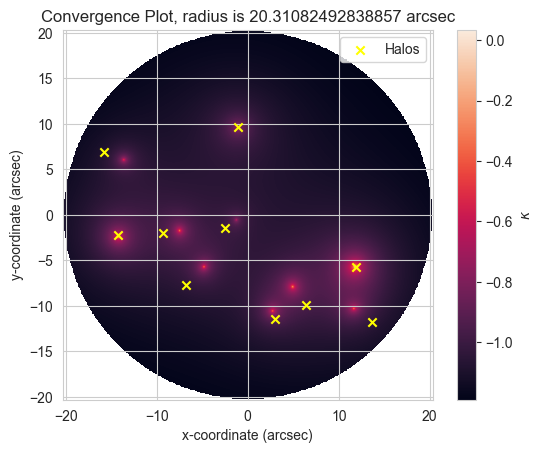

In [3]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Instantiate the HalosLens class with the halo list computed above and a defined sky area
halos_lens = HalosLens(
    halos_list=halos,
    mass_correction_list=mass_sheet_correction,
    mass_sheet=True,
    sky_area=0.0001,
    cosmo=cosmo,
    samples_number=1000,
)
halos_lens.plot_convergence()

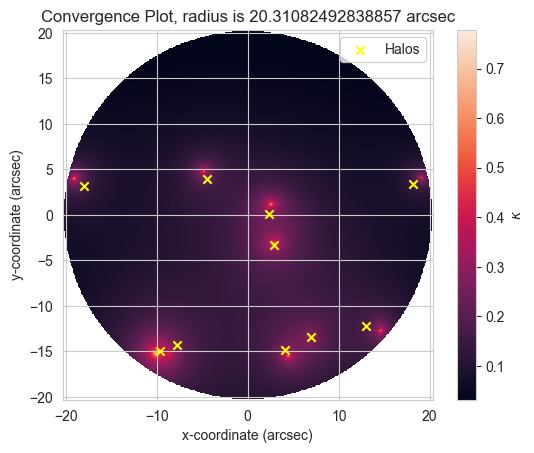

In [4]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Instantiate the HalosLens class with the halo list computed above and a defined sky area
halos_lens = HalosLens(
    halos_list=halos,
    mass_correction_list=None,    # No mass sheet correction
    mass_sheet=False,          # No mass sheet correction
    sky_area=0.0001,
    cosmo=cosmo,
    samples_number=1000,
)
halos_lens.plot_convergence()

In [19]:
halos_k, halos_g = run_halos_without_kde_by_multiprocessing(
    n_iterations=50,
    sky_area=0.00036,
    samples_number=100,
    cosmo=cosmo,
    z_max=5.0,
)

kappa_random_halos = convergence_mean_0(halos_k)
gamma_random_halos = halos_g 

/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 50 halo-lists took 6.051400899887085 seconds to run


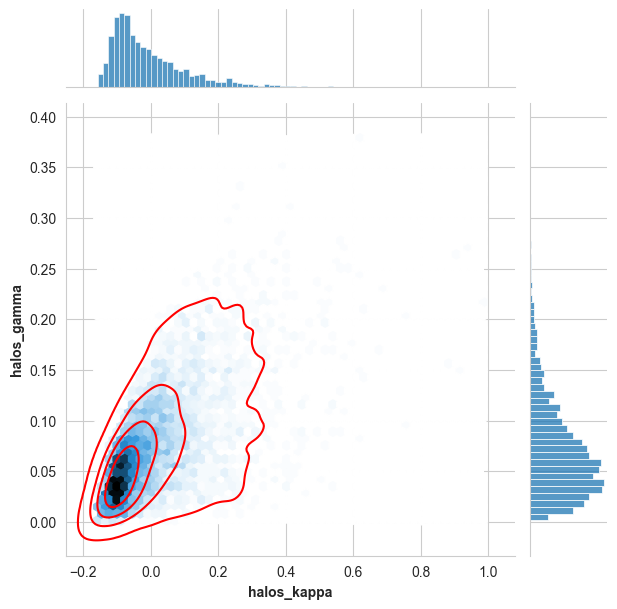

In [20]:
total_plot = sns.jointplot(x=kappa_random_halos, y=gamma_random_halos, kind="hex")
total_plot.plot_joint(sns.kdeplot, color="r", zorder=3, levels=5)
total_plot.ax_joint.set_xlabel("halos_kappa", fontweight="bold")
total_plot.ax_joint.set_ylabel("halos_gamma", fontweight="bold")
plt.show()

In [21]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
file_path = os.path.join(parent_directory, "data/glass/sampled_z1.7data.npy")

In [22]:
kappa_values, gamma_values, nside = read_glass_data(file_name=file_path)
skyarea = skyarea_form_n(nside)
kappa_random_glass, gamma_random_glass = generate_samples_from_glass(
    kappa_values, gamma_values, n=5000)
print(kappa_random_glass.shape, gamma_random_glass.shape)

(5000,) (5000,)


In [23]:
total_kappa, total_gamma = halos_plus_glass(
    kappa_random_glass, gamma_random_glass, kappa_random_halos, gamma_random_halos
)

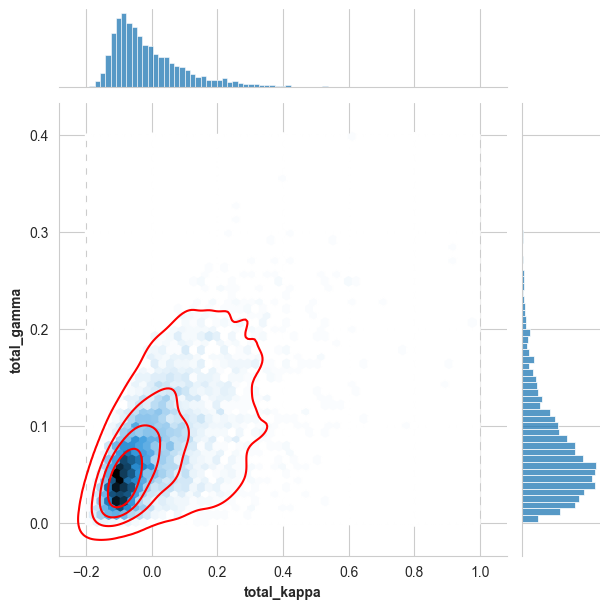

In [24]:
total_plot = sns.jointplot(x=total_kappa, y=total_gamma, kind="hex")
total_plot.plot_joint(sns.kdeplot, color="r", zorder=3, levels=5)
total_plot.ax_joint.set_xlabel("total_kappa", fontweight="bold")
total_plot.ax_joint.set_ylabel("total_gamma", fontweight="bold")
plt.show()

/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 100 halo-lists took 6.976924896240234 seconds to run
zs=1.5, zd=0.5,k_s_mean=-0.18585697924206904


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 100 halo-lists took 13.813783168792725 seconds to run
zs=1.5, zd=0.5,k_ext_mean=-0.10535730404224629
Variance of k_S: 0.0004526176671375884
Variance of k_ext: 0.0005413929699816763


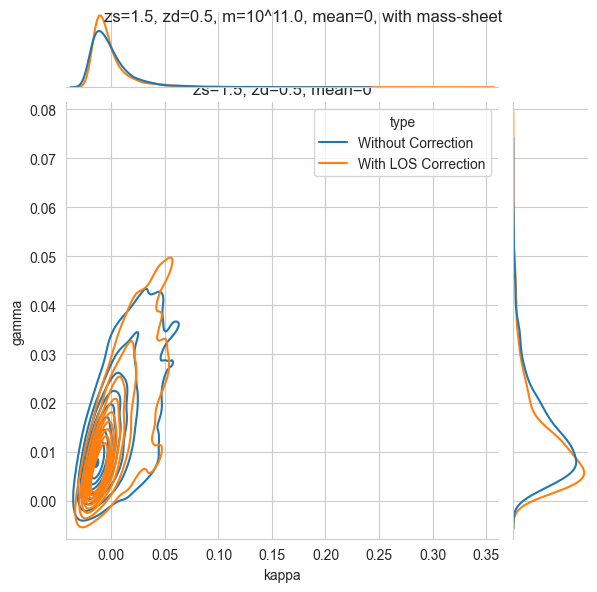

/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 100 halo-lists took 10.241535902023315 seconds to run
zs=2.5, zd=0.5,k_s_mean=-0.44766457090028067


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 100 halo-lists took 25.03394889831543 seconds to run
zs=2.5, zd=0.5,k_ext_mean=-0.1597877724933722
Variance of k_S: 0.0027391335920547537
Variance of k_ext: 0.0009224404513816577


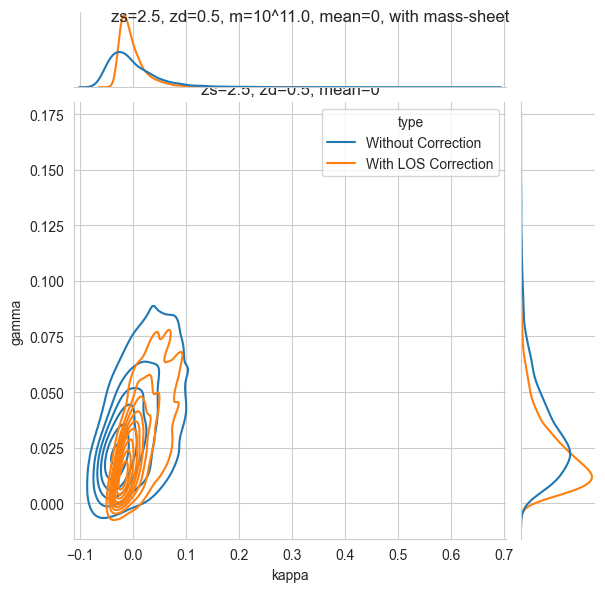

/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 100 halo-lists took 5.5500328540802 seconds to run
zs=1.0, zd=0.5,k_s_mean=-0.07907003242063877


/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/tz/Documents/GitHub/slsim/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/s

The 100 halo-lists took 9.493234872817993 seconds to run
zs=1.0, zd=0.5,k_ext_mean=-0.06790529863909808
Variance of k_S: 0.00024524148759292095
Variance of k_ext: 0.0002066202358015709


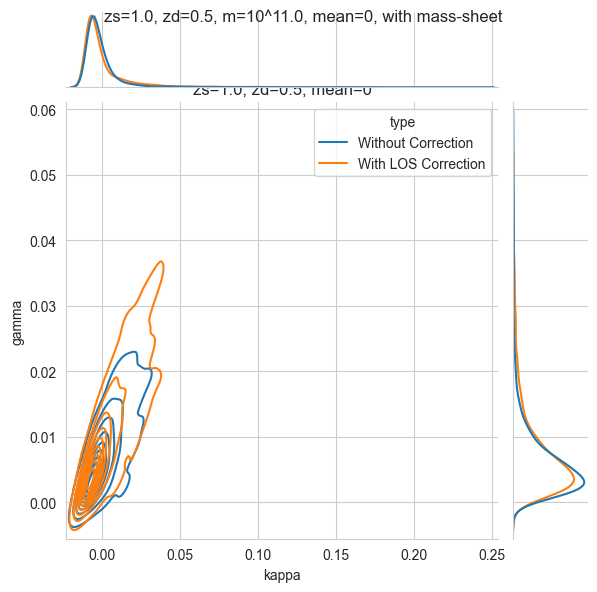

In [26]:
def plot_kappa_gamma(zs=1.5, zd=0.5, n_iterations=100, sky_area=0.00036, samples_number=30, m_min='1.0E+12', m_max='1.0E+16'):
    # Setup Cosmology
    cosmo = default_cosmology.get()
    # Without Correction
    nk, ng = run_halos_without_kde_by_multiprocessing(n_iterations=n_iterations, 
                                                      sky_area=sky_area, 
                                                      samples_number=samples_number, 
                                                      cosmo=cosmo, 
                                                      m_min=m_min, 
                                                      m_max=m_max,
                                                      z_max=zs, 
                                                      listmean=False)
    nk_mean = sum(nk) / len(nk)
    print(f"zs={zs}, zd={zd},k_s_mean={nk_mean}")
    nk = convergence_mean_0(nk)
    
    # With Correction
    distribution = run_certain_redshift_lensext_kde_by_multiprocessing(n_iterations=n_iterations, 
                                                                       sky_area=sky_area,
                                                                       samples_number=samples_number, 
                                                                       cosmo=cosmo, 
                                                                       m_min=m_min, 
                                                                       m_max=m_max, 
                                                                       z_max=zs, 
                                                                       zs=zs, 
                                                                       zd=zd, 
                                                                       listmean=False)
    nk1 = [point[0] for point in distribution]
    ng1 = [point[1] for point in distribution]
    nk1_mean = sum(nk1) / len(nk1)
    print(f"zs={zs}, zd={zd},k_ext_mean={nk1_mean}")
    nk1 = convergence_mean_0(nk1)


    # Combine Data for Joint KDE Plot
    df1 = pd.DataFrame({'x': nk, 'y': ng, 'type': 'Without Correction'})
    df2 = pd.DataFrame({'x': nk1, 'y': ng1, 'type': 'With LOS Correction'})
    df_total = pd.concat([df1, df2], axis=0)

    var_nk = np.var(nk)
    var_nk1 = np.var(nk1)
    print(f"Variance of k_S: {var_nk}")
    print(f"Variance of k_ext: {var_nk1}")

    # Plotting
    plot = sns.jointplot(data=df_total, x="x", y="y", hue="type", kind="kde")

    plot.ax_joint.set_xlabel("kappa")
    plot.ax_joint.set_ylabel("gamma")
    m_min_float = float(m_min)
    plt.title(f'zs={zs}, zd={zd}, mean=0')
    plot.fig.suptitle(f"zs={zs}, zd={zd}, m=10^{np.log10(m_min_float)}, mean=0, with mass-sheet")
   # plot.ax_joint.set_xlim(-0.2, 0.2)

    plt.show()

# To use the function:
plot_kappa_gamma(zs=1.5, zd=0.5,m_min='1.0E+11', m_max='1.0E+16')
plot_kappa_gamma(zs=2.5, zd=0.5,m_min='1.0E+11', m_max='1.0E+16')
plot_kappa_gamma(zs=1.0, zd=0.5,m_min='1.0E+11', m_max='1.0E+16')